# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [43]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# magic word for producing visualizations in notebook
%matplotlib inline

from yellowbrick.cluster import KElbowVisualizer # Importing Elbow Method Library
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans # Importing K-Means algorithm 
from sklearn.metrics import mean_squared_error # Evaluation metric 
from sklearn.model_selection import train_test_split # Preprocessing for training and testing data splits 

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [44]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Daniel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [45]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Data Exploration:
    1. Observe datatypes
    2. Find percentage of NaN values

In [46]:
print("The number of customers left after processing: {}".format(len(customers)))

The number of customers left after processing: 191652


In [47]:
customers.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [48]:
null_count = []
for i in customers:
    value = customers[i].isnull().sum()
    null_count.append(value)

print("Percentage of null values in each column:")
for i in range(len(null_count)-1):
    print("{}: {:.2f}%".format(customers.columns[i], (null_count[i]/customers.shape[0] * 100)))

Percentage of null values in each column:
LNR: 0.00%
AGER_TYP: 0.00%
AKT_DAT_KL: 24.31%
ALTER_HH: 24.31%
ALTER_KIND1: 93.86%
ALTER_KIND2: 97.34%
ALTER_KIND3: 99.33%
ALTER_KIND4: 99.88%
ALTERSKATEGORIE_FEIN: 27.05%
ANZ_HAUSHALTE_AKTIV: 26.05%
ANZ_HH_TITEL: 27.19%
ANZ_KINDER: 24.31%
ANZ_PERSONEN: 24.31%
ANZ_STATISTISCHE_HAUSHALTE: 26.05%
ANZ_TITEL: 24.31%
ARBEIT: 26.34%
BALLRAUM: 26.07%
CAMEO_DEU_2015: 26.31%
CAMEO_DEUG_2015: 26.31%
CAMEO_INTL_2015: 26.31%
CJT_GESAMTTYP: 1.68%
CJT_KATALOGNUTZER: 1.68%
CJT_TYP_1: 1.68%
CJT_TYP_2: 1.68%
CJT_TYP_3: 1.68%
CJT_TYP_4: 1.68%
CJT_TYP_5: 1.68%
CJT_TYP_6: 1.68%
D19_BANKEN_ANZ_12: 0.00%
D19_BANKEN_ANZ_24: 0.00%
D19_BANKEN_DATUM: 0.00%
D19_BANKEN_DIREKT: 0.00%
D19_BANKEN_GROSS: 0.00%
D19_BANKEN_LOKAL: 0.00%
D19_BANKEN_OFFLINE_DATUM: 0.00%
D19_BANKEN_ONLINE_DATUM: 0.00%
D19_BANKEN_ONLINE_QUOTE_12: 24.89%
D19_BANKEN_REST: 0.00%
D19_BEKLEIDUNG_GEH: 0.00%
D19_BEKLEIDUNG_REST: 0.00%
D19_BILDUNG: 0.00%
D19_BIO_OEKO: 0.00%
D19_BUCH_CD: 0.00%
D19_DIGIT_SERV

In [49]:
for i in customers:
    print(i)
    print(customers[i].unique())

LNR
[  9626   9628 143872 ... 148813 148852 148883]
AGER_TYP
[ 2 -1  1  0  3]
AKT_DAT_KL
[ 1.  9.  3.  7.  5.  2. nan  4.  6.  8.]
ALTER_HH
[10. 11.  6.  8. 20.  5. 14. 21. 15. 17.  0. 19.  9. 12. 13. nan 18.  7.
 16.  4.  2.  3.]
ALTER_KIND1
[nan  8. 12.  9.  7. 13. 17. 14. 18. 11. 16.  6. 10. 15.  5.  3.  4.  2.]
ALTER_KIND2
[nan  9. 17. 10. 14. 13. 12. 11. 16. 18. 15.  7.  5.  8.  6.  3.  2.  4.]
ALTER_KIND3
[nan 13. 16. 18. 15. 17. 14. 12. 11. 10.  8.  7.  9.  6.  5.]
ALTER_KIND4
[nan 18. 12. 16. 13. 17. 11. 14. 15. 10.  8.]
ALTERSKATEGORIE_FEIN
[10. nan  0.  8. 14.  9.  4. 13.  6. 12. 19. 17. 15. 11. 16.  7. 18. 21.
 25. 20. 24.  5.  2. 22.  3. 23.]
ANZ_HAUSHALTE_AKTIV
[  1.  nan   0.   7.  74.   9.  17.  12.  29.   2.  45.  10.  14.  15.
  55.   6.   5. 108.   3.  25.  18.   4.  11.  19.   8.  26.  43.  63.
  47.  16.  31.  57.  37.  13.  22.  20.  23.  27. 305.  52.  21.  34.
  46.  24.  33.  51. 523. 104. 101.  59.  44.  38.  61.  69.  28.  48.
  40.  39. 145. 107.  32.  76. 11

[ 2. nan  5.  3.  1.  4.  0.  9.]
KBA05_HERST5
[ 2. nan  3.  1.  0.  4.  5.  9.]
KBA05_HERSTTEMP
[ 2. nan  3.  1.  4.  5.  9.]
KBA05_KRSAQUOT
[ 4. nan  3.  2.  1.  5.  9.]
KBA05_KRSHERST1
[ 4. nan  2.  3.  5.  1.  9.]
KBA05_KRSHERST2
[ 3. nan  4.  2.  1.  5.  9.]
KBA05_KRSHERST3
[ 3. nan  2.  1.  4.  5.  9.]
KBA05_KRSKLEIN
[ 2. nan  1.  3.  9.]
KBA05_KRSOBER
[ 3. nan  2.  1.  9.]
KBA05_KRSVAN
[ 3. nan  2.  1.  9.]
KBA05_KRSZUL
[ 2. nan  3.  1.  9.]
KBA05_KW1
[ 3. nan  2.  5.  4.  1.  9.]
KBA05_KW2
[ 3. nan  4.  2.  1.  5.  9.]
KBA05_KW3
[ 3. nan  0.  4.  1.  2.  9.]
KBA05_MAXAH
[ 5. nan  3.  4.  2.  1.  9.]
KBA05_MAXBJ
[ 2. nan  4.  1.  3.  9.]
KBA05_MAXHERST
[ 2. nan  4.  3.  1.  5.  9.]
KBA05_MAXSEG
[ 3. nan  2.  1.  4.  9.]
KBA05_MAXVORB
[ 2. nan  1.  3.  9.]
KBA05_MOD1
[ 2. nan  0.  1.  4.  3.  9.]
KBA05_MOD2
[ 4. nan  3.  5.  2.  1.  9.]
KBA05_MOD3
[ 3. nan  4.  5.  1.  2.  9.]
KBA05_MOD4
[ 4. nan  3.  0.  1.  2.  5.  9.]
KBA05_MOD8
[ 2. nan  1.  0.  3.  9.]
KBA05_MODTEMP
[ 2. nan

[0 1]
ANREDE_KZ
[1 2]
ALTERSKATEGORIE_GROB
[4 3 2 1 9]


In [50]:
for i in range(0, customers.shape[1]):     
        if (customers.iloc[:, i].dtypes == 'object'):
            print(customers.columns[i])

CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015
D19_LETZTER_KAUF_BRANCHE
EINGEFUEGT_AM
OST_WEST_KZ
PRODUCT_GROUP
CUSTOMER_GROUP


In [51]:
customers['CAMEO_DEU_2015'].unique()

array(['1A', nan, '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B',
       '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D',
       '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E',
       '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F',
       '4D', 'XX'], dtype=object)

In [52]:
customers['CAMEO_DEUG_2015'].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [53]:
customers['CAMEO_INTL_2015'].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

In [54]:
customers['D19_LETZTER_KAUF_BRANCHE'].unique()

array(['D19_UNBEKANNT', 'D19_BANKEN_GROSS', 'D19_NAHRUNGSERGAENZUNG',
       'D19_SCHUHE', 'D19_BUCH_CD', 'D19_DROGERIEARTIKEL', 'D19_SONSTIGE',
       'D19_TECHNIK', 'D19_VERSICHERUNGEN', 'D19_TELKO_MOBILE',
       'D19_VOLLSORTIMENT', nan, 'D19_HAUS_DEKO', 'D19_ENERGIE',
       'D19_REISEN', 'D19_BANKEN_LOKAL', 'D19_VERSAND_REST',
       'D19_BEKLEIDUNG_REST', 'D19_FREIZEIT', 'D19_BEKLEIDUNG_GEH',
       'D19_TELKO_REST', 'D19_SAMMELARTIKEL', 'D19_BANKEN_DIREKT',
       'D19_KINDERARTIKEL', 'D19_BANKEN_REST', 'D19_LEBENSMITTEL',
       'D19_GARTEN', 'D19_HANDWERK', 'D19_RATGEBER', 'D19_DIGIT_SERV',
       'D19_BIO_OEKO', 'D19_BILDUNG', 'D19_WEIN_FEINKOST',
       'D19_TIERARTIKEL', 'D19_LOTTO', 'D19_KOSMETIK'], dtype=object)

In [55]:
customers['EINGEFUEGT_AM'].unique()

array(['1992/02/12 00:00', nan, '1992/02/10 00:00', ...,
       '2008/04/25 00:00', '2005/03/30 00:00', '2008/07/14 00:00'],
      dtype=object)

In [56]:
customers['OST_WEST_KZ'].unique()

array(['W', nan, 'O'], dtype=object)

### Data Preprocessing
- The goal here is to remove any duplicates, remove missing values and drop unnecessary columns.  

In [57]:
customers.drop_duplicates(keep = 'first', inplace = True)

In [58]:
azdias.drop_duplicates(keep = 'first', inplace = True)

In [62]:
def preprocessing (dataframe):
    """Cleaning of dataframe for better data processing. """
    dataframe = dataframe.copy()
    dataframe = dataframe.set_index(['LNR']) # Set the Customer ID to index of dataframe

    #dataframe.drop_duplicates(keep = 'first', inplace = True) # Removes any duplicates from the 
    #dataframe.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'EINGEFUEGT_AM'], axis=1, inplace=True) # Drops LNR which is the customer id 
    
    dataframe.replace(-1, float('NaN'), inplace=True) # -1 values represent missing values, and will be replaced with NaN values
    dataframe.replace(0, float('NaN'), inplace=True) # 0 values represent unknown values, and will be replaced with NaN values
    
    dataframe['CAMEO_DEU_2015'].replace('XX', dataframe['CAMEO_DEU_2015'].mode().iloc[0], inplace=True) # Replace unknown string to mode value
    
    dataframe['CAMEO_DEUG_2015'].replace('X', dataframe['CAMEO_DEUG_2015'].mode().iloc[0], inplace=True)
    dataframe['CAMEO_DEUG_2015'] = dataframe['CAMEO_DEUG_2015'].apply(pd.to_numeric) # Convert to integer values
    
    dataframe['CAMEO_INTL_2015'].replace('XX', dataframe['CAMEO_INTL_2015'].mode().iloc[0], inplace=True)
    dataframe['CAMEO_INTL_2015'] = dataframe['CAMEO_INTL_2015'].apply(pd.to_numeric) # Convert to integer values
    
    new_list = []
            
    for i in dataframe:
        dataframe[i] = dataframe[i].fillna(dataframe[i].mode().iloc[0]) # Mode is used to replace NaN values due to categorical values
    
    
    for i in range(0, dataframe.shape[1]):     
        if (dataframe.iloc[:, i].dtypes == 'object'): # All object dtypes to be converted to categorical values
            dataframe.iloc[:, i] = pd.Categorical(dataframe.iloc[:, i])
            dataframe.iloc[:, i] = dataframe.iloc[:, i].cat.codes 
            dataframe.iloc[:, i] = dataframe.iloc[:, i].astype('int64')
            new_list.append(dataframe.columns[i])
    
    
    return dataframe # return cleaned dataframe

In [63]:
# Preprocessing of Customers dataframe
cleaned_customers = preprocessing(customers)
cleaned_customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2.0,1.0,10.0,18.0,18.0,18.0,18.0,10.0,1.0,1.0,...,2.0,6.0,9.0,7.0,3,1,0,1.0,1,4
9628,2.0,9.0,11.0,18.0,18.0,18.0,18.0,10.0,1.0,1.0,...,3.0,6.0,9.0,3.0,3,2,1,1.0,1,4
143872,2.0,1.0,6.0,18.0,18.0,18.0,18.0,10.0,1.0,1.0,...,11.0,6.0,9.0,2.0,3,1,0,1.0,2,4
143873,1.0,1.0,8.0,18.0,18.0,18.0,18.0,8.0,1.0,1.0,...,2.0,6.0,9.0,7.0,1,0,0,1.0,1,4
143874,2.0,1.0,20.0,18.0,18.0,18.0,18.0,14.0,7.0,1.0,...,4.0,2.0,9.0,3.0,1,2,0,1.0,1,3


In [64]:
# Dropping specific columns with greater than 40% NaN values
cleaned_customers.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4','KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'EINGEFUEGT_AM'], axis=1, inplace=True)

### Data Processing Confirmation
- This step is to confirm that the data has been thoroughly cleaned for data analysis. 

In [65]:
print("The number of customers left after processing: {}".format(len(cleaned_customers)))

The number of customers left after processing: 191652


In [66]:
null_count = []
for i in cleaned_customers:
    value = cleaned_customers[i].isnull().sum()
    null_count.append(value)

print("Percentage of null values in each column:")
for i in range(len(null_count)-1):
    print("{}: {:.2f}%".format(cleaned_customers.columns[i], (null_count[i]/cleaned_customers.shape[0] * 100)))

Percentage of null values in each column:
AGER_TYP: 0.00%
AKT_DAT_KL: 0.00%
ALTER_HH: 0.00%
ALTERSKATEGORIE_FEIN: 0.00%
ANZ_HAUSHALTE_AKTIV: 0.00%
ANZ_HH_TITEL: 0.00%
ANZ_KINDER: 0.00%
ANZ_PERSONEN: 0.00%
ANZ_STATISTISCHE_HAUSHALTE: 0.00%
ANZ_TITEL: 0.00%
ARBEIT: 0.00%
BALLRAUM: 0.00%
CAMEO_DEU_2015: 0.00%
CAMEO_DEUG_2015: 0.00%
CAMEO_INTL_2015: 0.00%
CJT_GESAMTTYP: 0.00%
CJT_KATALOGNUTZER: 0.00%
CJT_TYP_1: 0.00%
CJT_TYP_2: 0.00%
CJT_TYP_3: 0.00%
CJT_TYP_4: 0.00%
CJT_TYP_5: 0.00%
CJT_TYP_6: 0.00%
D19_BANKEN_ANZ_12: 0.00%
D19_BANKEN_ANZ_24: 0.00%
D19_BANKEN_DATUM: 0.00%
D19_BANKEN_DIREKT: 0.00%
D19_BANKEN_GROSS: 0.00%
D19_BANKEN_LOKAL: 0.00%
D19_BANKEN_OFFLINE_DATUM: 0.00%
D19_BANKEN_ONLINE_DATUM: 0.00%
D19_BANKEN_ONLINE_QUOTE_12: 0.00%
D19_BANKEN_REST: 0.00%
D19_BEKLEIDUNG_GEH: 0.00%
D19_BEKLEIDUNG_REST: 0.00%
D19_BILDUNG: 0.00%
D19_BIO_OEKO: 0.00%
D19_BUCH_CD: 0.00%
D19_DIGIT_SERV: 0.00%
D19_DROGERIEARTIKEL: 0.00%
D19_ENERGIE: 0.00%
D19_FREIZEIT: 0.00%
D19_GARTEN: 0.00%
D19_GESAMT_ANZ

### General Population Data Processing 

In [67]:
cleaned_population = preprocessing(azdias)
cleaned_population.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910215,2.0,1.0,18.0,18.0,18.0,18.0,17.0,15.0,1.0,1.0,...,2.0,10.0,10.0,10.0,6.0,9.0,3.0,3,1,2
910220,2.0,9.0,18.0,18.0,18.0,18.0,17.0,21.0,11.0,1.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
910225,2.0,9.0,17.0,18.0,18.0,18.0,17.0,17.0,10.0,1.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
910226,2.0,1.0,13.0,18.0,18.0,18.0,17.0,13.0,1.0,1.0,...,2.0,7.0,10.0,11.0,6.0,9.0,7.0,3,2,4
910241,2.0,1.0,20.0,18.0,18.0,18.0,17.0,14.0,3.0,1.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [68]:
# Dropping specific columns with greater than 60% NaN values
cleaned_population.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4','KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'EINGEFUEGT_AM'], axis=1, inplace=True)
cleaned_population.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910215,2.0,1.0,18.0,15.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,10.0,10.0,10.0,6.0,9.0,3.0,3,1,2
910220,2.0,9.0,18.0,21.0,11.0,1.0,1.0,2.0,12.0,1.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
910225,2.0,9.0,17.0,17.0,10.0,1.0,1.0,1.0,7.0,1.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
910226,2.0,1.0,13.0,13.0,1.0,1.0,1.0,1.0,2.0,1.0,...,2.0,7.0,10.0,11.0,6.0,9.0,7.0,3,2,4
910241,2.0,1.0,20.0,14.0,3.0,1.0,1.0,4.0,3.0,1.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


## Side note: 
- Due to the size of the data, processing the data can be computationally intensive. The preferred method for imputation is KNN imputation. However, this takes roughly 1 hour for processing the Customers csv file and likely much longer for the general population. The decision was made to use Mode for imputation instead. KNN imputation would have been more representative of the actual data. 

In [69]:
#from sklearn.impute import KNNImputer # Importing K Nearest Neighbors Algorithm
# K Nearest Neighbours algorithm is used to replace values with its nearest neighbours - or most similar row data

#def knn_imputation(dataframe):
#    cleaned_dataframe = pd.DataFrame(KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean').fit(dataframe).transform(dataframe), columns = dataframe.columns)
#    return cleaned_dataframe

In [70]:
# Code for viewing distinct values within a column

#for i in cleaned_customers:
#    print(cleaned_customers[i].unique())

## Data Modelling:
- Now that the data has been cleaned, the data is now available for modelling. In this stage, we will opt to use Principal Component Analysis (PCA) to reduce the dimensionality of the data. In other words, we will take the dataset of 365 columns and reduce it to just a few. 
- After the dimensionality has been reduced, the data will be clustered to form distinct groups of customers using K-means clustering. 

### 1. Principal Component Analysis 

In [ ]:
sc = StandardScaler()
cleaned_customers = sc.fit_transform(cleaned_customers)

In [71]:
pca = PCA(n_components=20)
X_df = pca.fit(cleaned_customers).transform(cleaned_customers)
PCA_components = pd.DataFrame(X_df)
sum(pca.explained_variance_ratio_)

0.9988805708828414

([<matplotlib.axis.XTick at 0x2c435114780>,
 <a list of 20 Text xticklabel objects>)

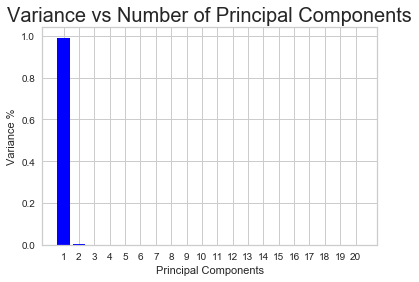

In [72]:
pc_range = range(1, pca.n_components_+1)
plt.title("Variance vs Number of Principal Components", size=20)
plt.bar(pc_range, pca.explained_variance_ratio_, color='blue')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(pc_range)

Observation: From the chart, we can see a distinct drop-off after the second component. This means that the majority of the data can be explained by using only two principal components. 

In [80]:
pca = PCA(n_components=2)
X_df = pca.fit(cleaned_customers).transform(cleaned_customers)
pca.explained_variance_ratio_

array([0.99099937, 0.00206462])

### 2. K-Means Clustering 

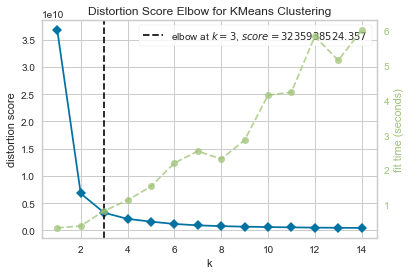

In [74]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,15)) # Loop through model to find ideal number of clusters within the data

visualizer.fit(PCA_components)
#visualizer.fit(cleaned_customers)
visualizer.show()

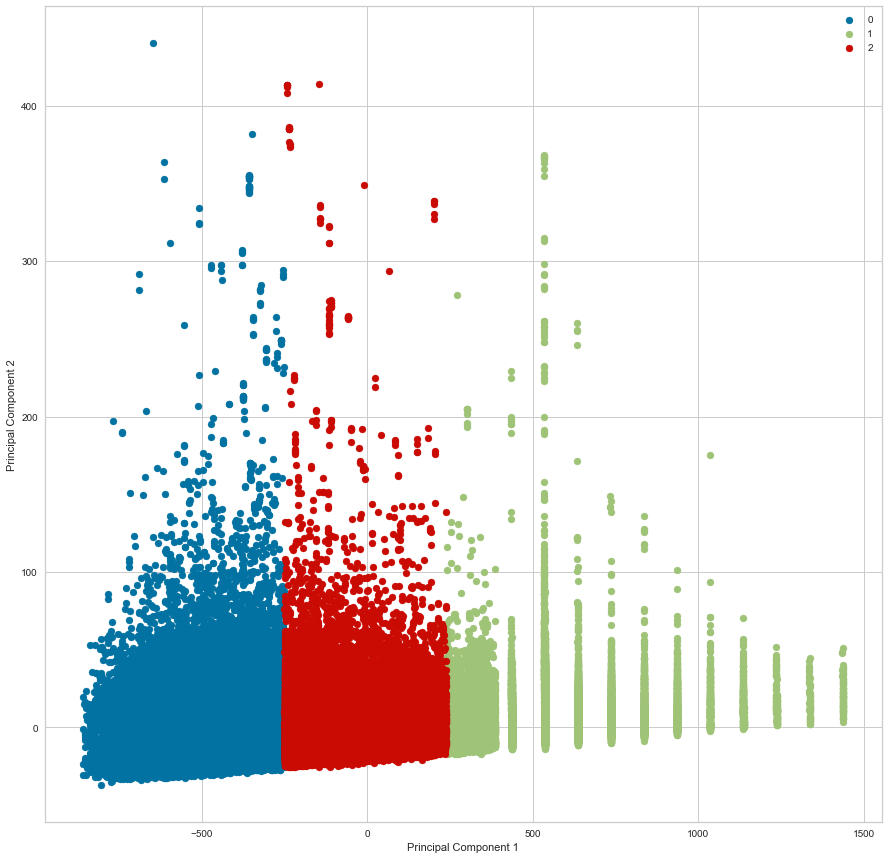

In [75]:
k_means_model = KMeans(n_clusters = 3, init = "k-means++")
k_means_pred = k_means_model.fit_predict(X_df) # Fitting the data onto the K-means clustering algorithm
uniq = np.unique(k_means_pred)
plt.figure(figsize=(15,15))
for i in uniq:
  plt.scatter(X_df[k_means_pred == i , 0] , X_df[k_means_pred == i , 1] , label = i)

plt.xlabel([])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show() # Plotting the data onto a chart

In [76]:
cleaned_customers['cluster'] = k_means_model.labels_ # Adding extra column to the Customers dataframe to allocate data to separate groups
cleaned_customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2.0,1.0,10.0,10.0,1.0,1.0,1.0,2.0,1.0,1.0,...,6.0,9.0,7.0,3,1,0,1.0,1,4,1
9628,2.0,9.0,11.0,10.0,1.0,1.0,1.0,3.0,1.0,1.0,...,6.0,9.0,3.0,3,2,1,1.0,1,4,1
143872,2.0,1.0,6.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,...,6.0,9.0,2.0,3,1,0,1.0,2,4,0
143873,1.0,1.0,8.0,8.0,1.0,1.0,1.0,2.0,1.0,1.0,...,6.0,9.0,7.0,1,0,0,1.0,1,4,2
143874,2.0,1.0,20.0,14.0,7.0,1.0,1.0,4.0,7.0,1.0,...,2.0,9.0,3.0,1,2,0,1.0,1,3,0


In [77]:
# Locating the central locations of the clusters
array = k_means_model.cluster_centers_
array = array.astype(int)
array

array([[-438,    0,    1],
       [ 535,    0,    1],
       [ -60,    1,   -4]])

In [78]:
# Allocating the clustered groups onto different dataframes
dataframe_cluster_0 = cleaned_customers[cleaned_customers['cluster'] == 0]
dataframe_cluster_1 = cleaned_customers[cleaned_customers['cluster'] == 1]
dataframe_cluster_2 = cleaned_customers[cleaned_customers['cluster'] == 2]

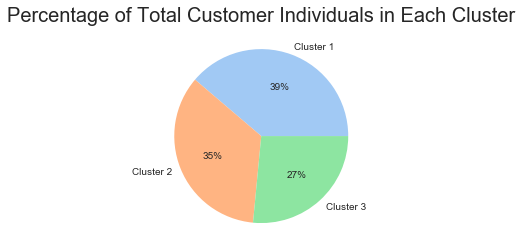

In [79]:
#define data
data = [len(dataframe_cluster_0), len(dataframe_cluster_1), len(dataframe_cluster_2)]
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.title('Percentage of Total Customer Individuals in Each Cluster', size = 20)
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()


### Modelling of General Population

In [82]:
pca = PCA(n_components=2)
pop_X_df = pca.fit(cleaned_population).transform(cleaned_population)
PCA_components = pd.DataFrame(pop_X_df)
sum(pca.explained_variance_ratio_)

MemoryError: Unable to allocate 2.37 GiB for an array with shape (357, 891221) and data type float64

In [83]:
k_means_pred = k_means_model.fit_predict(cleaned_population)

MemoryError: Unable to allocate 2.37 GiB for an array with shape (357, 891221) and data type float64

In [ ]:
cleaned_population['cluster'] = k_means_model.labels_ # Adding extra column to the Customers dataframe to allocate data to separate groups
cleaned_population.head()

In [ ]:
# Allocating the clustered groups onto different dataframes
pop_dataframe_cluster_0 = cleaned_population[cleaned_population['cluster'] == 0]
pop_dataframe_cluster_1 = cleaned_population[cleaned_population['cluster'] == 1]
pop_dataframe_cluster_2 = cleaned_population[cleaned_population['cluster'] == 2]

In [ ]:
#define data
data = [len(pop_dataframe_cluster_0), len(pop_dataframe_cluster_1), len(pop_dataframe_cluster_2)]
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.title('Percentage of Total Customer Individuals in Each Cluster', size = 20)
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

### Feature Importance in Cluster allocation
- After finding our clusters, it is important to identify the most influential features from the original dataframe. This will tells us which features will yield important information on our customers.

In [84]:
rfc_df = cleaned_customers.copy()
rfc_y = rfc_df.pop('cluster')
rfc_X = rfc_df[:]
rfc_X.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2.0,1.0,10.0,10.0,1.0,1.0,1.0,2.0,1.0,1.0,...,2.0,6.0,9.0,7.0,3,1,0,1.0,1,4
9628,2.0,9.0,11.0,10.0,1.0,1.0,1.0,3.0,1.0,1.0,...,3.0,6.0,9.0,3.0,3,2,1,1.0,1,4
143872,2.0,1.0,6.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,...,11.0,6.0,9.0,2.0,3,1,0,1.0,2,4
143873,1.0,1.0,8.0,8.0,1.0,1.0,1.0,2.0,1.0,1.0,...,2.0,6.0,9.0,7.0,1,0,0,1.0,1,4
143874,2.0,1.0,20.0,14.0,7.0,1.0,1.0,4.0,7.0,1.0,...,4.0,2.0,9.0,3.0,1,2,0,1.0,1,3


In [85]:
rfc_y.head()

LNR
9626      1
9628      1
143872    0
143873    2
143874    0
Name: cluster, dtype: int32

In [86]:

rfc_X_train, rfc_X_test, rfc_y_train, rfc_y_test = train_test_split(rfc_X, rfc_y) # Splitting the data into training and testing datasets

MemoryError: Unable to allocate 459. MiB for an array with shape (314, 191652) and data type float64

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(rfc_X_train, rfc_y_train)
rfc_pred = rfc.predict(rfc_X_test)

In [ ]:
print ("Accuracy : {:.2f}%".format(accuracy_score(rfc_y_test, rfc_pred)*100))

In [87]:
rfc_array = rfc.feature_importances_

NameError: name 'rfc' is not defined

In [ ]:
#df = pd.DataFrame(array.reshape(1, 368), columns=X.columns)
# Arranging the most important features into a list
rfc_importances = []
count = 0
for i in rfc_array:
    rfc_importances.append([i, rfc_X.columns[count]])
    count += 1

In [ ]:
# Sorting the feature importances from maximum importance to least.
rfc_importances.sort(reverse=True)
rfc_labels = []
rfc_values = []
for i in rfc_importances[0:20]:
    rfc_labels.append(i[1])
    rfc_values.append(i[0])

rfc_importances[0:20]

In [ ]:
sns.barplot(rfc_labels, rfc_values)
plt.xticks(rotation=90)
plt.title('Feature Importances in Cluster Allocation', size = 20)

Important: There is no background information on 'EINGEFUEGT_AM', 'KOMBIALTER', 'KBA05_HERSTTEMP', 'MIN_GEBAEUDEJAHR' 'KBA05_MODTEMP'. These seem to play an important role in the factors influencing cluster segmentation. It's not possible to decifer what these feature are related to and how they are represented. 

#OST_WEST_KZ
#CAMEO_DEUG_2015
#PLZ8_HHZ

## Exploratory Data Analysis
- Here we will be looking at some characteristics of the customers population, as well as the most important features in the dataset. 
- Due to the nature of the dataset, we will refer to the "DIAS Attributes - Values 2017" csv file to understand the meaning of the categorical values. 

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Distribution of Gender in Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['ANREDE_KZ'],  ax=axes[0], color ='red', bins = 2, kde = False)
sns.distplot(dataframe_cluster_1['ANREDE_KZ'],  ax=axes[1], color ='red', bins = 2, kde = False)
sns.distplot(dataframe_cluster_2['ANREDE_KZ'],  ax=axes[2], color ='red', bins = 2, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Distribution of Gender in Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['GEBURTSJAHR'],  ax=axes[0], color ='red', bins = 2, kde = False)
sns.distplot(dataframe_cluster_1['GEBURTSJAHR'],  ax=axes[1], color ='red', bins = 2, kde = False)
sns.distplot(dataframe_cluster_2['GEBURTSJAHR'],  ax=axes[1], color ='red', bins = 2, kde = False)

### Observations:
- The majority of customers are male. 
- The first cluster has a more even distribution of males to females as compared to the other two clusters. 

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Distribution of Age in Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['ALTERSKATEGORIE_GROB'],  ax=axes[0], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_1['ALTERSKATEGORIE_GROB'],  ax=axes[1], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_2['ALTERSKATEGORIE_GROB'],  ax=axes[2], color ='red', bins = 10, kde = False)

### Oberservations:
- The first cluster has a younger population with individuals falling into the category of less than 30 years of age, and between the ages of 30 and 45. 
- The second cluster tends to have a larger population of middle aged individuals ranging from 46 - 60 years of age. 
- The third cluster has the largest percentage of individuals who are over the age of 60 years of age

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Transaction level of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['D19_VERSAND_ONLINE_DATUM'],  ax=axes[0], color ='red', bins = 20, kde = False)
sns.distplot(dataframe_cluster_1['D19_VERSAND_ONLINE_DATUM'],  ax=axes[1], color ='red', bins = 20, kde = False)
#sns.distplot(dataframe_cluster_2['D19_VERSAND_ONLINE_DATUM'],  ax=axes[2], color ='red', bins = 20, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Distance from City Center of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['BALLRAUM'],  ax=axes[0], color ='red', bins = 20, kde = False)
sns.distplot(dataframe_cluster_1['BALLRAUM'],  ax=axes[1], color ='red', bins = 20, kde = False)
#sns.distplot(dataframe_cluster_2['BALLRAUM'],  ax=axes[2], color ='red', bins = 20, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Online Transaction Activity of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['D19_VERSAND_ONLINE_DATUM'],  ax=axes[0], color ='red', bins = 20, kde = False)
sns.distplot(dataframe_cluster_1['D19_VERSAND_ONLINE_DATUM'],  ax=axes[1], color ='red', bins = 20, kde = False)
sns.distplot(dataframe_cluster_2['D19_VERSAND_ONLINE_DATUM'],  ax=axes[2], color ='red', bins = 20, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Online Transactions within all Transactions in the Segment Mail-Order of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['D19_VERSAND_ONLINE_QUOTE_12'],  ax=axes[0], color ='red', bins = 20, kde = False)
sns.distplot(dataframe_cluster_1['D19_VERSAND_ONLINE_QUOTE_12'],  ax=axes[1], color ='red', bins = 20, kde = False)
sns.distplot(dataframe_cluster_2['D19_VERSAND_ONLINE_QUOTE_12'],  ax=axes[2], color ='red', bins = 20, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Rough Social Status of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['LP_STATUS_GROB'],  ax=axes[0], color ='red', bins = 3, kde = False)
sns.distplot(dataframe_cluster_1['LP_STATUS_GROB'],  ax=axes[1], color ='red', bins = 3, kde = False)
#sns.distplot(dataframe_cluster_2['LP_STATUS_GROB'],  ax=axes[2], color ='red', bins = 3, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Good Social Status of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['LP_STATUS_FEIN'],  ax=axes[0], color ='red', bins = 3, kde = False)
sns.distplot(dataframe_cluster_1['LP_STATUS_FEIN'],  ax=axes[1], color ='red', bins = 3, kde = False)
#sns.distplot(dataframe_cluster_2['LP_STATUS_FEIN'],  ax=axes[2], color ='red', bins = 3, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Class of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['CAMEO_DEUG_2015'],  ax=axes[0], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_1['CAMEO_DEUG_2015'],  ax=axes[1], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_2['CAMEO_DEUG_2015'],  ax=axes[2], color ='red', bins = 10, kde = False)

In [ ]:
dataframe_cluster_1['CAMEO_DEUG_2015'].unique()

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Number of Cars in Postal Code Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['KBA13_ANZAHL_PKW'],  ax=axes[0], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_1['KBA13_ANZAHL_PKW'],  ax=axes[1], color ='red', bins = 10, kde = False)
#sns.distplot(dataframe_cluster_2['KBA13_ANZAHL_PKW'],  ax=axes[2], color ='red', bins = 10, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Number of Households in Postal Code Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['PLZ8_HHZ'],  ax=axes[0], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_1['PLZ8_HHZ'],  ax=axes[1], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_2['PLZ8_HHZ'],  ax=axes[2], color ='red', bins = 10, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Development of Most Recent Car Segment in Postal Code Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['KBA05_MODTEMP'],  ax=axes[0], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_1['KBA05_MODTEMP'],  ax=axes[1], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_2['KBA05_MODTEMP'],  ax=axes[2], color ='red', bins = 10, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Development of Most Recent Car Manufacturer in Postal Code Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['KBA05_HERSTTEMP'],  ax=axes[0], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_1['KBA05_HERSTTEMP'],  ax=axes[1], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_2['KBA05_HERSTTEMP'],  ax=axes[2], color ='red', bins = 10, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Number of Buildings in Postal Code Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['PLZ8_GBZ'],  ax=axes[0], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_1['PLZ8_GBZ'],  ax=axes[1], color ='red', bins = 10, kde = False)
sns.distplot(dataframe_cluster_2['PLZ8_GBZ'],  ax=axes[2], color ='red', bins = 10, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Share of Cars Per Household of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['KBA13_AUTOQUOTE'],  ax=axes[0], color ='red', bins = 5, kde = False)
sns.distplot(dataframe_cluster_1['KBA13_AUTOQUOTE'],  ax=axes[1], color ='red', bins = 5, kde = False)
sns.distplot(dataframe_cluster_2['KBA13_AUTOQUOTE'],  ax=axes[2], color ='red', bins = 5, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Residential Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['WOHNLAGE'],  ax=axes[0], color ='red', bins = 8, kde = False)
sns.distplot(dataframe_cluster_1['WOHNLAGE'],  ax=axes[1], color ='red', bins = 8, kde = False)
sns.distplot(dataframe_cluster_2['WOHNLAGE'],  ax=axes[2], color ='red', bins = 8, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Unemployment of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['RELAT_AB'],  ax=axes[0], color ='red', bins = 6, kde = False)
sns.distplot(dataframe_cluster_1['RELAT_AB'],  ax=axes[1], color ='red', bins = 6, kde = False)
sns.distplot(dataframe_cluster_2['RELAT_AB'],  ax=axes[2], color ='red', bins = 6, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Unemployment of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['KBA13_KMH_0_140'],  ax=axes[0], color ='red', bins = 5, kde = False)
sns.distplot(dataframe_cluster_1['KBA13_KMH_0_140'],  ax=axes[1], color ='red', bins = 5, kde = False)
sns.distplot(dataframe_cluster_2['KBA13_KMH_0_140'],  ax=axes[2], color ='red', bins = 5, kde = False)

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('West or East Germany of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['OST_WEST_KZ'],  ax=axes[0], color ='red', bins = 2, kde = False)
sns.distplot(dataframe_cluster_1['OST_WEST_KZ'],  ax=axes[1], color ='red', bins = 2, kde = False)
sns.distplot(dataframe_cluster_2['OST_WEST_KZ'],  ax=axes[2], color ='red', bins = 2, kde = False)

In [ ]:
filtered_customers = cleaned_customers.filter(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'BALLRAUM', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 
                                       'D19_BANKEN_ANZ_24',
                          'D19_BANKEN_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_DATUM',
                           'D19_VERSAND_ONLINE_QUOTE_12', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
                          'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR',
                          'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
                          'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
                          'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
                          'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
                           'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
                          'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 
                           'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
                           'ONLINE_AFFINITAET', 'REGIOTYP'])

for i in filtered_customers:
        filtered_customers[i] = filtered_customers[i].astype(int)

In [ ]:
#sns.set_theme(style="white")

# Obtaining correlation matrix
#corr_df = filtered_customers.copy() #.drop(['cluster'], axis=1)
corr = filtered_customers.corr()

# Matplotlib graph setup 
f, ax = plt.subplots(figsize=(20, 20))

# Generating Seaplot colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 1}, fmt=".2f")

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
train_csv = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
train_csv.head()

In [ ]:
train_csv.drop_duplicates(keep = 'first', inplace = True)

In [ ]:
def preprocessing (dataframe):
    """Cleaning of dataframe for better data processing. """
    dataframe = dataframe.copy()
    dataframe = dataframe.set_index(['LNR']) # Set the Customer ID to index of dataframe

    #dataframe.drop_duplicates(keep = 'first', inplace = True) # Removes any duplicates from the 
    dataframe.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'EINGEFUEGT_AM'], axis=1, inplace=True) # Drops LNR which is the customer id 
    
    dataframe.replace(-1, float('NaN'), inplace=True) # -1 values represent missing values, and will be replaced with NaN values
    dataframe.replace(0, float('NaN'), inplace=True) # 0 values represent unknown values, and will be replaced with NaN values
    
    dataframe['CAMEO_DEU_2015'].replace('XX', dataframe['CAMEO_DEU_2015'].mode().iloc[0], inplace=True) # Replace unknown string to mode value
    
    dataframe['CAMEO_DEUG_2015'].replace('X', dataframe['CAMEO_DEUG_2015'].mode().iloc[0], inplace=True)
    dataframe['CAMEO_DEUG_2015'] = dataframe['CAMEO_DEUG_2015'].apply(pd.to_numeric) # Convert to integer values
    
    dataframe['CAMEO_INTL_2015'].replace('XX', dataframe['CAMEO_INTL_2015'].mode().iloc[0], inplace=True)
    dataframe['CAMEO_INTL_2015'] = dataframe['CAMEO_INTL_2015'].apply(pd.to_numeric) # Convert to integer values
    
    new_list = []
            
    for i in dataframe:
        dataframe[i] = dataframe[i].fillna(dataframe[i].mode().iloc[0]) # Mode is used to replace NaN values due to categorical values
    
    dataframe = pd.get_dummies(dataframe)
    
    """for i in range(0, dataframe.shape[1]):     
        if (dataframe.iloc[:, i].dtypes == 'object'): # All object dtypes to be converted to categorical values
            dataframe.iloc[:, i] = pd.Categorical(dataframe.iloc[:, i])
            dataframe.iloc[:, i] = dataframe.iloc[:, i].cat.codes 
            dataframe.iloc[:, i] = dataframe.iloc[:, i].astype('int64')
            new_list.append(dataframe.columns[i])"""
    
    
    return dataframe # return cleaned dataframe

In [ ]:
# Function for viewing the number of positive responses
def response_counter(response_array):
    """Counts the number of positive and negative responses in purchasing. """
    number_of_yes = 0 
    number_of_no = 0
    for i in response_array:
        if i == 1:
            number_of_yes += 1
        else:
            number_of_no += 1
    return number_of_yes, number_of_no

In [ ]:
# Obtaining obtaining target features 
y = train_csv.pop('RESPONSE') # Pop off target fature 
X = train_csv[:] # Store features in separate variable for processing
X.head()

In [ ]:
X = preprocessing(X)
X.head()

In [ ]:
# Viewing number of target feature rows
print(y.unique())
# Number of unique values in target feature
print(y.nunique())

In [ ]:
number_of_yes, number_of_no = response_counter(y)
print("The number of yes responses in target column is {}, and the number of no responses is {}".format(number_of_yes, number_of_no))

### Modelling of Supervised Learning Model 
- The goal is to:
    - Normalize the features
    - Create training, testing and validation datasets
    - Train the model using a Random Forest Classifier or XGBoost Model 
    - Evaluate the model

In [ ]:
sc = StandardScaler()
scaled_X = sc.fit_transform(X)

In [ ]:
pca = PCA(n_components=200)
X_df = pca.fit(scaled_X).transform(scaled_X)
pca.explained_variance_ratio_

In [ ]:
#std_wine = StandardScaler().fit_transform(filtered_customers)

#pca = PCA(n_components=20)
#principalComponents = pca.fit_transform(filtered_customers)

PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)
plt.title("Variance vs Number of Principal Components", size=20)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(X_df)

In [ ]:
pca = PCA(n_components=250)
X_df = pca.fit(scaled_X).transform(scaled_X)
print(sum(pca.explained_variance_ratio_))

In [ ]:
response_counter(y)

In [ ]:
# Split data into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=2, stratify=y)

### XGBoost

In [ ]:
model.get_params().keys()

In [ ]:
xgboost_model = xgb.XGBClassifier(colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, n_estimators=10, subsample=0.8, e_label_encoder=False)

param_grid = {
    'n_estimators': [10, 100, 200],
    #min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    #colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

#gboost_model = GridSearchCV(model, param_grid, scoring='roc_auc', verbose=3)
xgboost_model.fit(X_train, y_train)
#ND colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, n_estimators=10, subsample=0.8;, score=0.780 total time=   0.4s

In [ ]:
xgb_pred = xgboost_model.predict(X_test)

In [ ]:
print(xgboost_model.best_params_)

In [ ]:
# Assessing the accuracy of the XGBoost 
from sklearn.metrics import accuracy_score
xgb_pred = xgboost_model.predict(X_test)
print ("Accuracy : {:.2f}%".format(accuracy_score(y_test, xgb_pred)*100))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_pred))

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, xgb_pred)

In [ ]:
import pickle
filename = 'XGBoost.pkl'
pickle.dump(xgboost_model, open(filename, 'wb'))

## Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(random_state = 42)
    
parameters = {
            'n_estimators': [200],#, 500],
            'max_features': ['auto'],#, 'sqrt', 'log2'],
            'max_depth' : [4],#,5,6,7,8],
            'criterion' :['gini']#, 'entropy']
            }
    
cv = GridSearchCV(rfc, param_grid=parameters, verbose = 3, scoring='roc_auc')
rfc.fit(X_train, y_train)

In [ ]:
rfc.best_params_

In [ ]:
rfc_pred = rfc.predict(X_test)

In [ ]:
print ("Accuracy : {:.2f}%".format(accuracy_score(y_test, rfc_pred)*100))

In [ ]:
print(classification_report(y_test, rfc_pred))

In [ ]:
print(roc_auc_score(y_test, rfc_pred)

In [ ]:
rfc_pred = rfc.predict(X_test)
print ("Accuracy : {:.2f}%".format(accuracy_score(y_test, rfc_pred)*100))
print(classification_report(y_test, rfc_pred))

In [ ]:
filename = 'RandomForestClassifier.pkl'
pickle.dump(rfc, open(filename, 'wb'))

## AdaBoost 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

f1 = make_scorer(f1_score)
ada_model = AdaBoostClassifier()
param_grid = {
    'n_estimators':[100]
}
# Train Adaboost Classifer
ada_model = GridSearchCV(ada_model, param_grid, scoring='roc_auc', verbose=3)
ada_model.fit(X_train, y_train)

In [ ]:
ada_pred = ada_model.predict(X_test)

In [ ]:
print ("Accuracy : {:.2f}%".format(accuracy_score(y_test, ada_pred)*100))

In [ ]:
print(classification_report(y_test, ada_pred))

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, ada_pred)

## Predicting Purchasing Patterns on Customers
- In this section, each cluster of customers will have their data fitted onto the trained SVM. Once the data has been fitted, we will see which customers are most likely to purchase the financial services product. 

In [ ]:
predicted_dataframe_cluster_1 = dataframe_cluster_0.copy()
predicted_dataframe_cluster_2 = dataframe_cluster_1.copy()
predicted_dataframe_cluster_3 = dataframe_cluster_2.copy()

In [ ]:
def prediction_function(dataframe):
    """Predicts the number of postive responses per customer group. """
    dataframe.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'cluster'], axis=1, inplace=True)
    #pca = PCA(n_components=250)
    #X_component = pca.fit(dataframe).transform(dataframe)
    #sc = StandardScaler()
    #X_component = sc.fit_transform(dataframe)
    y_pred = rfc.predict(dataframe)
    dataframe['prediction'] = y_pred
    number_of_yes, number_of_no = response_counter(dataframe['prediction'])
    print("Number of Purchase Responses: {}".format(number_of_yes))
    print("Percentage of Responses: {:.2f}%".format(number_of_yes/(number_of_yes + number_of_no) * 100))

In [ ]:
prediction_function(predicted_dataframe_cluster_1)

In [ ]:
cluster_2_pred = prediction_function(predicted_dataframe_cluster_2)
cluster_2_pred

In [ ]:
cluster_3_pred = prediction_function(predicted_dataframe_cluster_3)
cluster_3_pred

## Test Dataset

In [ ]:
test_csv = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')
test_csv.head()

In [ ]:
X = test_csv[:]

In [ ]:
X = preprocessing(test_csv)

In [ ]:
scaled_X = sc.fit_transform(X)

In [ ]:
r_pred = rfc.predict_proba(scaled_X)
#ada_pred = ada_model.predict(X_df)
xgb_pred = xgboost_model.predict_proba(scaled_X)
xgb_pred

In [ ]:
pred_csv = pd.DataFrame()

In [ ]:
pred_csv['LNR'] = test_csv['LNR']

In [ ]:
pred_csv.head()

In [ ]:
# Ensemble technique to improve accuracy of predictions on test dataset
pred_csv['rfc_response'] = r_pred[:, 1]
pred_csv['xgb_response'] = xgb_pred[:, 1]
pred_csv['RESPONSE'] = (pred_csv['rfc_response']+ pred_csv['xgb_response'])/3 # Return the average probablity between the models

In [ ]:
pred_csv.head()

In [ ]:
pred_csv.drop(['rfc_response', 'xgb_response'], axis=1, inplace=True)

In [ ]:
pred_csv.head()

In [ ]:
pred_csv.to_csv("Arvato_Test_prediction.csv", index=False)

In [ ]:
# Public Score of 0.75

### Total Consumer Base

In [ ]:
azdias_df = pca.fit(cleaned_population).transform(cleaned_population)
pca.explained_variance_ratio_

In [ ]:
label2 = k_means_model.fit_predict(azdias_df)

In [ ]:
cleaned_population['cluster'] = k_means_model.labels_
cleaned_population.head()

In [ ]:
cleaned_population['prediction'] = label2
number_of_yes_pop, number_of_no_pop = response_counter(cleaned_population['prediction'])
print("Percentage of Responses: {:.2f}%".format(number_of_yes_pop/(number_of_yes_pop + number_of_no_pop)))
print("Number of Purchase Responses: {}".format(number_of_yes_pop))

In [ ]:
labels = ['Customers', 'Potential Customers']
data = [498, 64896]

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:4]

#create pie chart
plt.title('Total Addressable Market', size = 20)
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

# Conclusion: 

From the data we can conclude that the first cluster has the highest chance of purchasing the mail-order product. These tend to be younger individuals, from area codes where the number of cars is smaller and the number of buildings in the postal codes are fewer than the two other groups of individuals. 

This may hint at the idea that the most likely purchasers of the mail-order product are younger individuals below the ages of 46 and that are living in areas experiencing economic growth as the number of new car manufacturers and buildings are increasing. The data also suggests that this group of people make up the majority of its customers - which is a positive sign. 

The supervised learning model scored roughly 72% of the test dataset on Kaggle. This is a relatively average performing model as the Customer dataset contains a lot of noise. Noise is likely unnecessary information that makes it difficult for the model to make accurate predictions. 